In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#model and tools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

# Upload the data

In [2]:
orders = pd.read_csv('orders.csv')
orders.date = pd.to_datetime(orders.date)
orders.head()

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 10:00:00,9
1,0,2021-04-01 11:00:00,1
2,0,2021-04-01 13:00:00,1
3,0,2021-04-01 14:00:00,1
4,0,2021-04-01 15:00:00,2


In [3]:
df_train = orders[(orders.date >= pd.to_datetime('2021-11-01')) & (orders.date < pd.to_datetime('2021-11-24'))]
df_test = orders[(orders.date >= pd.to_datetime('2021-11-24')) & (orders.date < pd.to_datetime('2021-12-01'))]

# Selection of areas with big number of orders

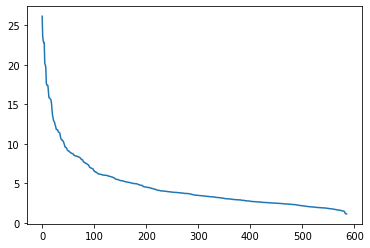

In [4]:
df_train_const = df_train.groupby(by='delivery_area_id', as_index=False).mean()

df_train_const_sort = df_train.groupby(by='delivery_area_id').mean()
df_train_const_sort = df_train_const_sort.sort_values(by='orders_cnt', ascending=False, ignore_index=True)
plt.plot(df_train_const_sort)

Thus we have about 50 areas with average number of orders bigger than 10.

In [5]:
df_train_const = df_train_const[df_train_const.orders_cnt >= 10]
df_train_const.head(20)

,delivery_area_id,orders_cnt
1,1,11.505455
3,4,14.223827
4,5,15.496377
7,8,11.843636
8,9,11.432886
9,10,11.763699
13,14,15.858621
16,17,23.022876
18,19,17.384615
19,20,17.413043


In [6]:
df_train = df_train[df_train.delivery_area_id.isin(df_train_const.delivery_area_id)]
df_test = df_test[df_test.delivery_area_id.isin(df_train_const.delivery_area_id)]

# Data normalization

In [7]:
for area in df_train_const.delivery_area_id.unique():
    norm = df_train_const[df_train_const.delivery_area_id==area].orders_cnt.to_list()[0]
    df_train.orders_cnt[df_train.delivery_area_id==area] = df_train.orders_cnt[df_train.delivery_area_id==area] / norm
    df_test.orders_cnt[df_test.delivery_area_id==area] = df_test.orders_cnt[df_test.delivery_area_id==area] / norm

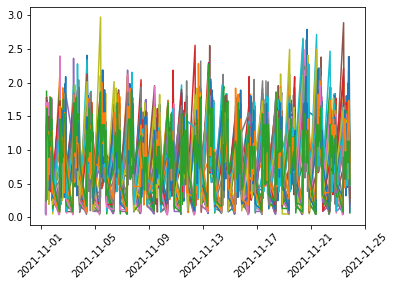

In [8]:
for area in df_train.delivery_area_id.unique():
    df = df_train[df_train.delivery_area_id==area]
    x, y = df.date, df.orders_cnt
    plt.plot(x, y)
    plt.xticks(rotation = 45)
plt.show()

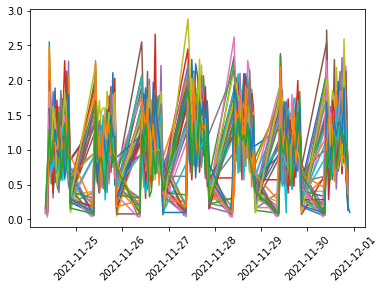

In [9]:
for area in df_test.delivery_area_id.unique():
    df = df_test[df_test.delivery_area_id==area]
    x, y = df.date, df.orders_cnt
    plt.plot(x, y)
    plt.xticks(rotation = 45)
plt.show()

So here we can see that the number of orders is periodical series and looks like stationar time-series.

# Stationarity check

p-value for original series of delivery area 1 0.0014782890428184444
p-value for original series of delivery area 4 0.0042425262901996845
p-value for original series of delivery area 5 0.0016935038275640358
p-value for original series of delivery area 8 0.02621850156239672
p-value for original series of delivery area 9 0.0298609914715747
p-value for original series of delivery area 10 0.13787721986849916
p-value for original series of delivery area 14 0.03006929338436301
p-value for original series of delivery area 17 0.05613068328732872
p-value for original series of delivery area 19 0.09376948305902155
p-value for original series of delivery area 20 0.17922425110366136
p-value for original series of delivery area 21 0.04943776642283956
p-value for original series of delivery area 23 0.009233280246076812
p-value for original series of delivery area 24 0.017913998114195147
p-value for original series of delivery area 25 0.020792848231124393
p-value for original series of delivery area 

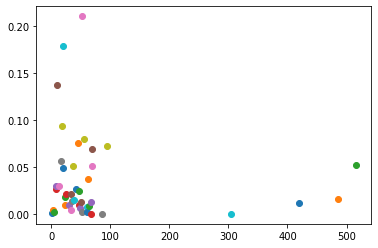

In [10]:
for area in df_test.delivery_area_id.unique():
    df = df_train[df_train.delivery_area_id==area]
    x_train, y_train = df.date, df.orders_cnt
    #df = df_test[df_test.delivery_area_id==area]
    #x_test, y_test = df.date, df.orders_cnt
    
    result = adfuller(y_train)
    print('p-value for original series of delivery area '+str(area), result[1])
    plt.scatter(area, result[1])

Here we can see that in general time series with zero order differencing is stationar. So we will use original timeseries.

# ARIMA model. Grid search p, q.

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
areas = np.array(df_test.delivery_area_id.unique())

In [13]:
p_range = np.arange(1, 18, 2)
q_range = np.arange(1, 28, 13)
MAPEs = np.empty(shape=((len(p_range)), len(q_range)))

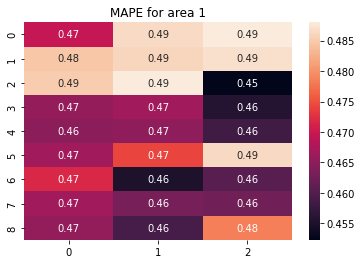

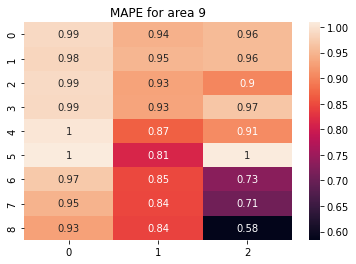

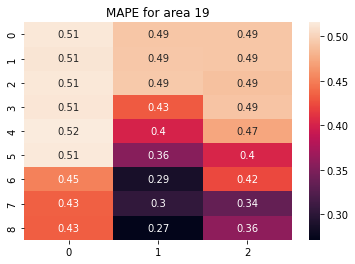

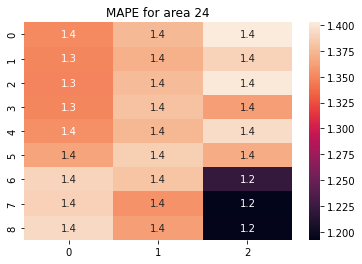

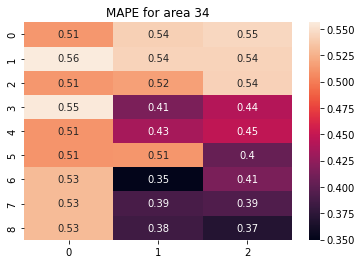

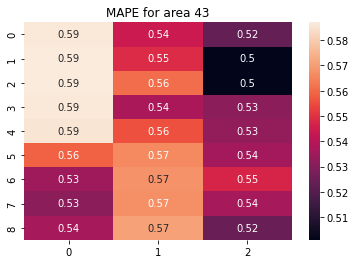

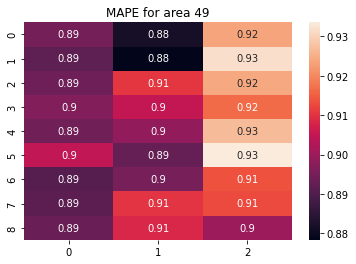

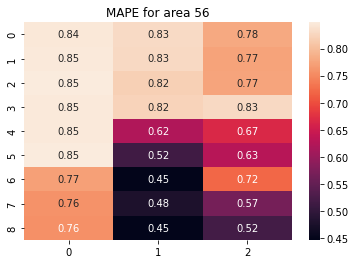

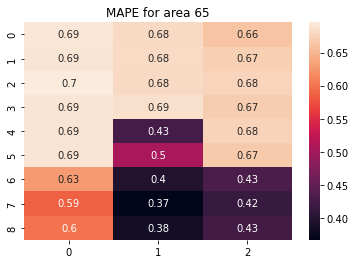

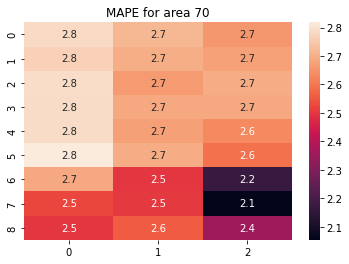

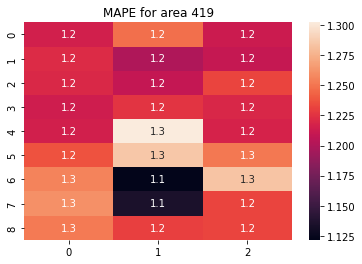

In [14]:
for area in areas[::4]:
    df = df_train[df_train.delivery_area_id==area]
    x_train, y_train = df.date, df.orders_cnt
    df = df_test[df_test.delivery_area_id==area]
    x_test, y_test = df.date, df.orders_cnt

    for idx_p, p in zip(range(len(p_range)), p_range):
        for idx_q, q in zip(range(len(q_range)), q_range):
            arima_model = ARIMA(y_train, order=(p, 0, q))
            model = arima_model.fit()

            y_pred = model.predict(start=len(x_train), end=len(x_train)+len(x_test)-1)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            MAPEs[idx_p, idx_q] = mape
            #print(p, q, mape)
            
    sns.heatmap(MAPEs, annot=True)
    plt.title('MAPE for area '+str(area))
    plt.show()

In [15]:
p_range = np.arange(18, 21, 1)
q_range = np.arange(12, 15, 1)
MAPEs = np.empty(shape=((len(p_range)), len(q_range)))

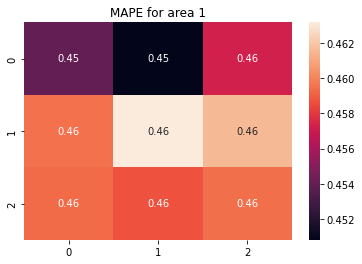

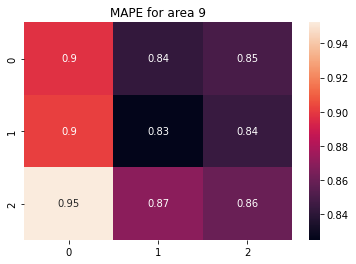

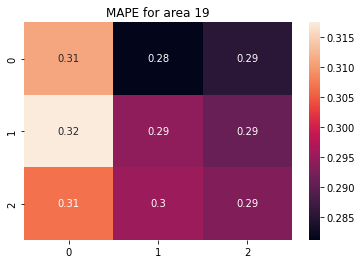

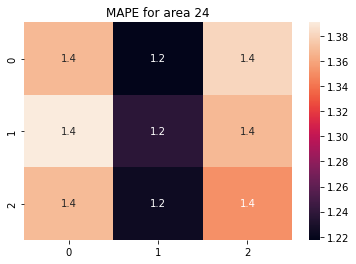

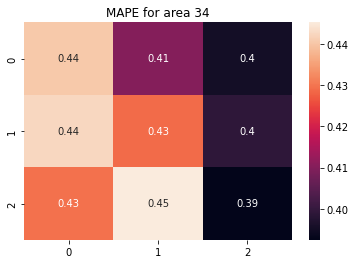

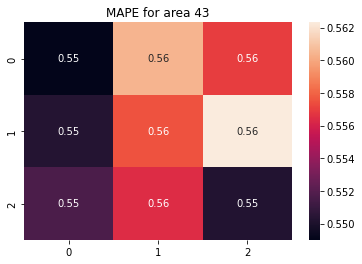

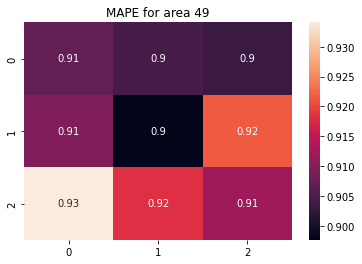

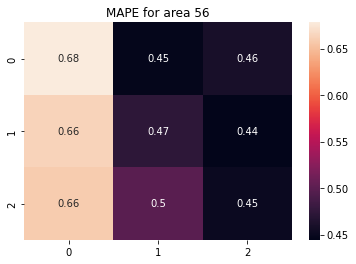

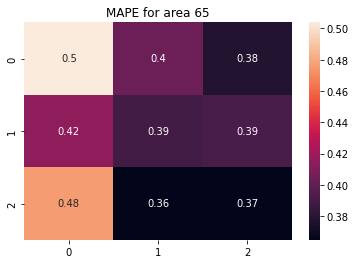

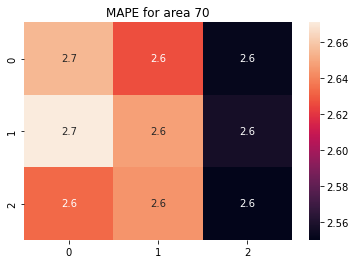

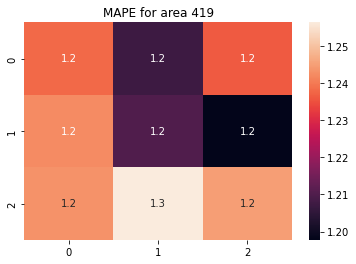

In [16]:
for area in areas[::4]:
    df = df_train[df_train.delivery_area_id==area]
    x_train, y_train = df.date, df.orders_cnt
    df = df_test[df_test.delivery_area_id==area]
    x_test, y_test = df.date, df.orders_cnt

    for idx_p, p in zip(range(len(p_range)), p_range):
        for idx_q, q in zip(range(len(q_range)), q_range):
            arima_model = ARIMA(y_train, order=(p, 0, q))
            model = arima_model.fit()

            y_pred = model.predict(start=len(x_train), end=len(x_train)+len(x_test)-1)
            mape = mean_absolute_percentage_error(y_test, y_pred)
            MAPEs[idx_p, idx_q] = mape
            #print(p, q, mape)
            
    sns.heatmap(MAPEs, annot=True)
    plt.title('MAPE for area '+str(area))
    plt.show()

So we will use ARIMA(18, 0, 13)

# Exapmle of ARIMA forecasting

In [17]:
area = 4
df = df_train[df_train.delivery_area_id==area]
x_train, y_train = df.date, df.orders_cnt
df = df_test[df_test.delivery_area_id==area]
x_test, y_test = df.date, df.orders_cnt

In [18]:
arima_model = ARIMA(y_train, order=(18, 0, 13))
model = arima_model.fit()

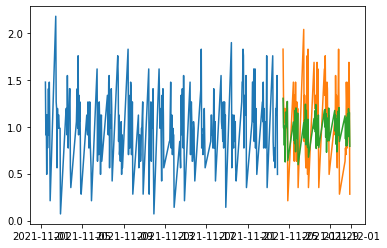

In [19]:
y_pred = model.predict(start=len(x_train), end=len(x_train)+len(x_test)-1)
plt.plot(x_train, y_train)
plt.plot(x_test, y_test)
plt.plot(x_test, y_pred)
plt.show()

In [20]:
mean_absolute_percentage_error(y_test, y_pred)

0.37219962916180666

# Delays overview

In [25]:
orders = pd.read_csv('orders.csv')
orders.date = pd.to_datetime(orders.date)
orders.head()

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 10:00:00,9
1,0,2021-04-01 11:00:00,1
2,0,2021-04-01 13:00:00,1
3,0,2021-04-01 14:00:00,1
4,0,2021-04-01 15:00:00,2


In [26]:
delays = pd.read_csv('partners_delays.csv')
delays.dttm = pd.to_datetime(delays.dttm)
delays.head()

,delivery_area_id,dttm,partners_cnt,delay_rate
0,0,2021-04-01 09:00:00,3.0,0.000000
1,0,2021-04-01 10:00:00,4.0,0.111111
2,0,2021-04-01 11:00:00,4.0,0.000000
3,0,2021-04-01 12:00:00,4.0,0.000000
4,0,2021-04-01 13:00:00,1.0,0.000000


In [27]:
orders = orders[(orders.date >= pd.to_datetime('2021-11-08')) & (orders.date < pd.to_datetime('2021-12-01'))]
orders = orders[orders.delivery_area_id.isin(df_train_const.delivery_area_id)]
delays = delays[(delays.date >= pd.to_datetime('2021-11-08')) & (delays.date < pd.to_datetime('2021-12-01'))]
delays = delays[delays.delivery_area_id.isin(df_train_const.delivery_area_id)]

In [45]:
orders

,delivery_area_id,date,orders_cnt
2839,1,2021-04-01 10:00:00,6
2840,1,2021-04-01 11:00:00,2
2841,1,2021-04-01 12:00:00,1
2842,1,2021-04-01 13:00:00,2
2843,1,2021-04-01 14:00:00,2
...,...,...,...
802699,516,2021-11-30 17:00:00,16
802700,516,2021-11-30 18:00:00,15
802701,516,2021-11-30 19:00:00,14
802702,516,2021-11-30 20:00:00,14


In [46]:
delays

,delivery_area_id,dttm,partners_cnt,delay_rate
3416,1,2021-04-01 08:00:00,2.0,0.000000
3417,1,2021-04-01 09:00:00,2.0,0.000000
3418,1,2021-04-01 10:00:00,3.0,0.166667
3419,1,2021-04-01 11:00:00,3.0,0.000000
3420,1,2021-04-01 12:00:00,1.0,1.000000
...,...,...,...,...
1118555,516,2021-11-30 18:00:00,7.0,0.133333
1118556,516,2021-11-30 19:00:00,6.0,0.071429
1118557,516,2021-11-30 20:00:00,6.0,0.214286
1118558,516,2021-11-30 21:00:00,4.0,0.111111


In [44]:
df = pd.concat([orders, delays])
df

,delivery_area_id,date,orders_cnt,dttm,partners_cnt,delay_rate
2839,1,2021-04-01 10:00:00,6.0,NaT,NaN,NaN
2840,1,2021-04-01 11:00:00,2.0,NaT,NaN,NaN
2841,1,2021-04-01 12:00:00,1.0,NaT,NaN,NaN
2842,1,2021-04-01 13:00:00,2.0,NaT,NaN,NaN
2843,1,2021-04-01 14:00:00,2.0,NaT,NaN,NaN
...,...,...,...,...,...,...
1118555,516,NaT,NaN,2021-11-30 18:00:00,7.0,0.133333
1118556,516,NaT,NaN,2021-11-30 19:00:00,6.0,0.071429
1118557,516,NaT,NaN,2021-11-30 20:00:00,6.0,0.214286
1118558,516,NaT,NaN,2021-11-30 21:00:00,4.0,0.111111


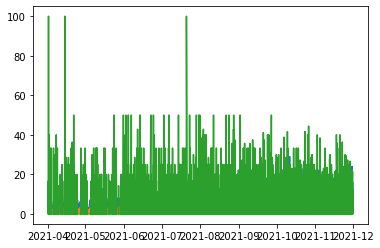

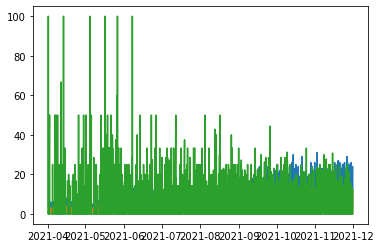

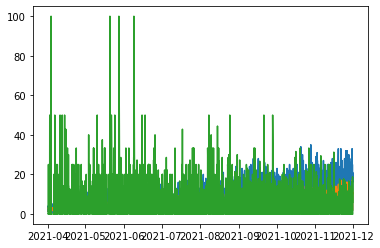

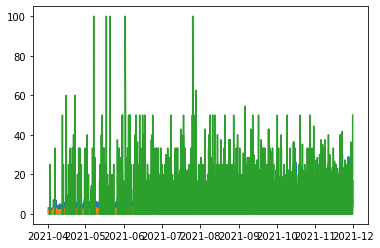

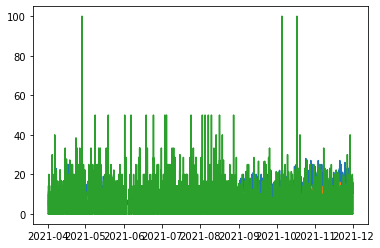

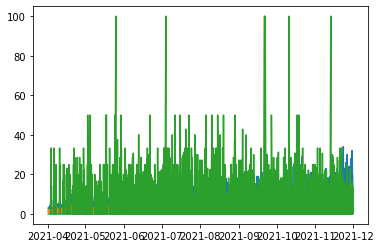

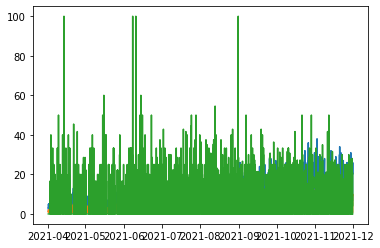

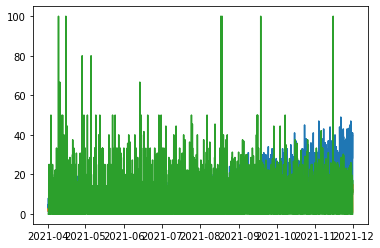

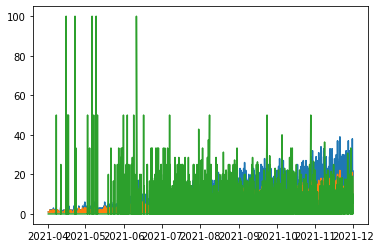

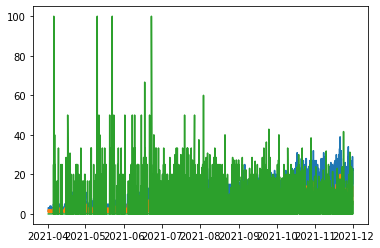

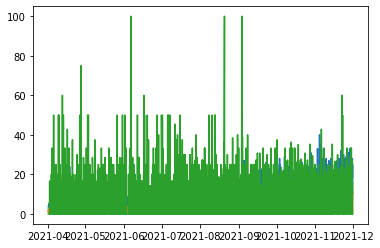

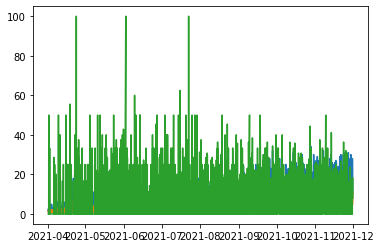

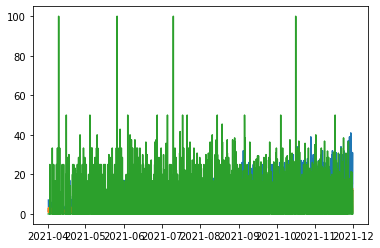

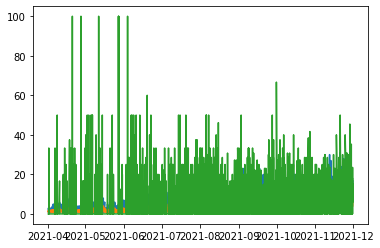

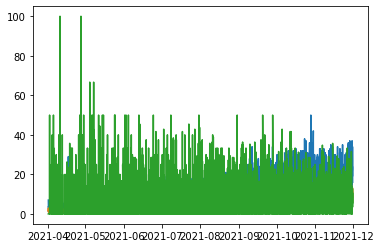

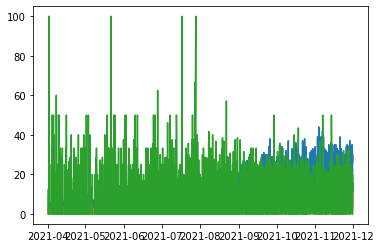

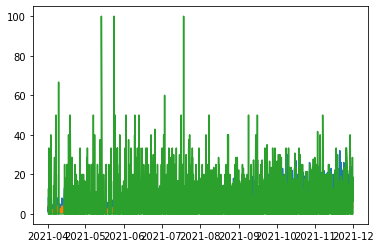

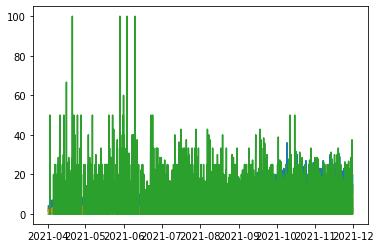

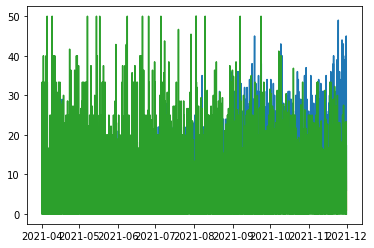

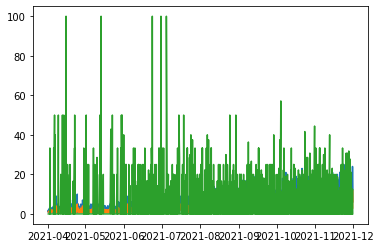

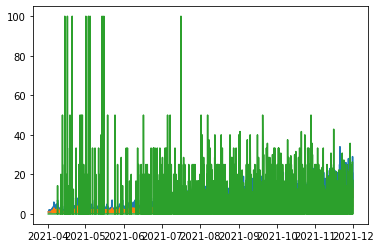

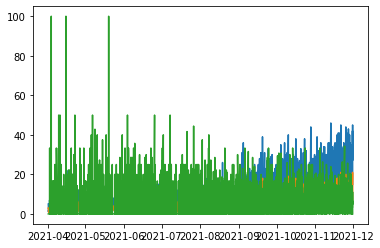

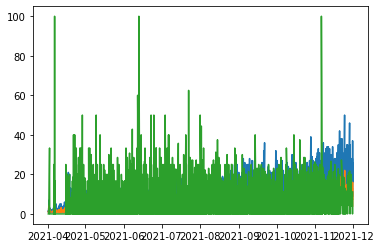

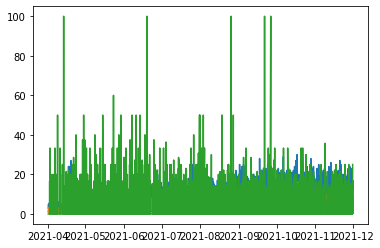

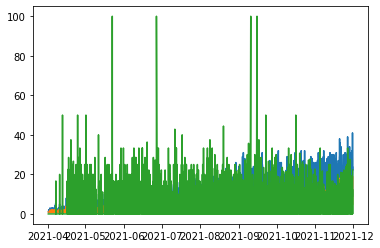

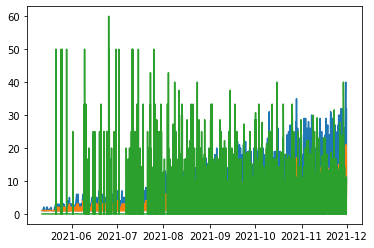

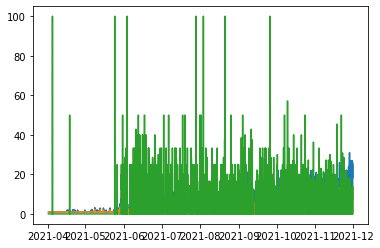

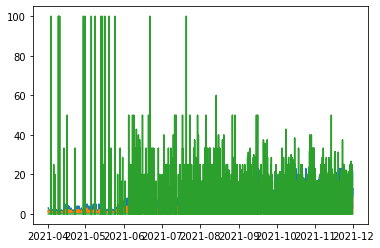

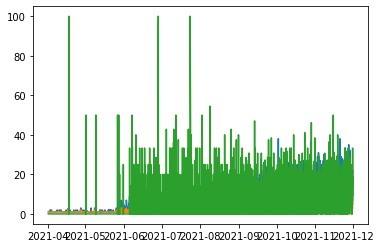

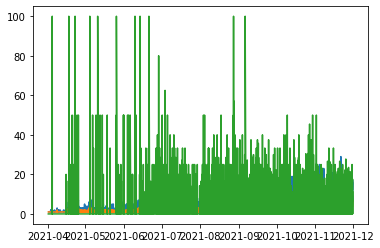

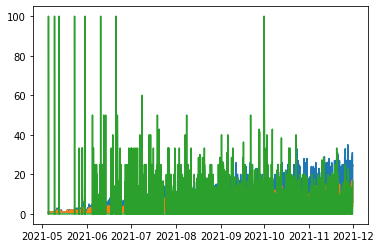

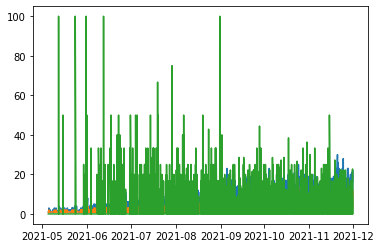

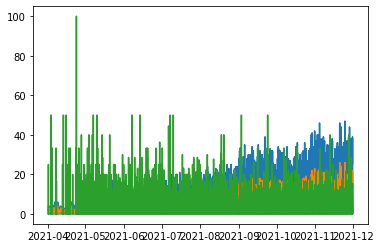

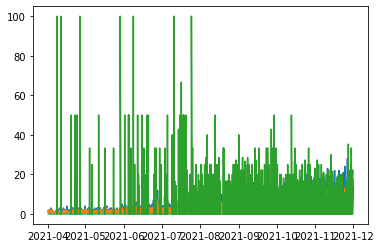

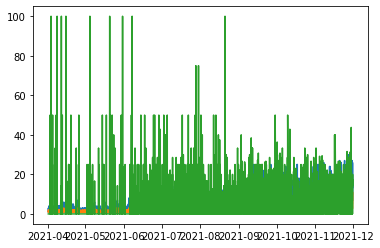

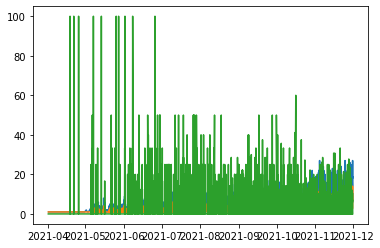

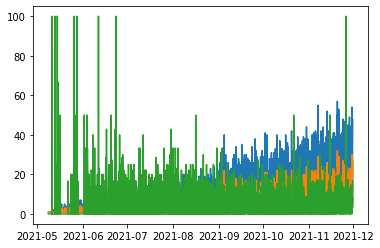

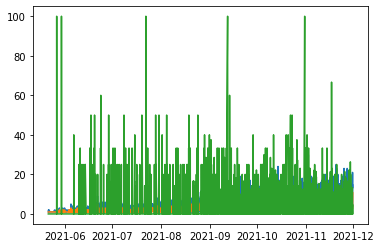

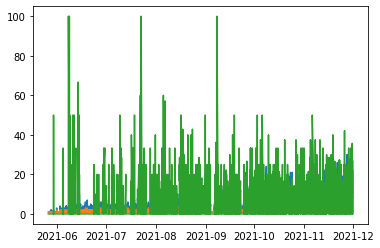

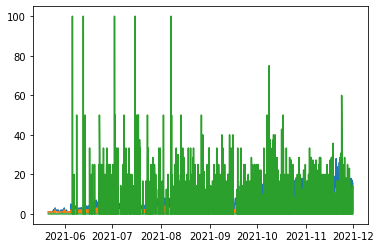

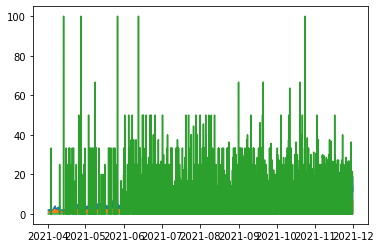

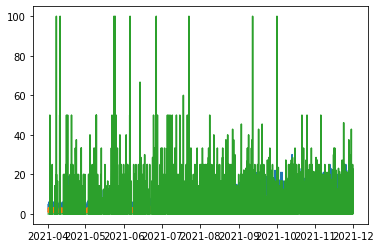

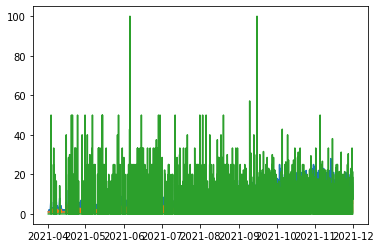

In [30]:
for area in areas:
    df_orders = orders[orders.delivery_area_id==area]
    df_delays = delays[delays.delivery_area_id==area]
    plt.plot(df_orders.date, df_orders.orders_cnt)
    plt.plot(df_delays.dttm, df_delays.partners_cnt)
    plt.plot(df_delays.dttm, 100*df_delays.delay_rate)
    plt.show()

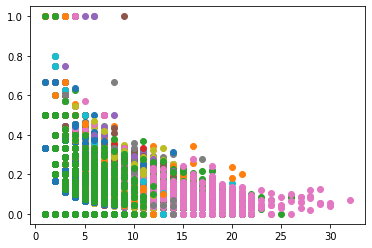

In [42]:
for area in areas:
    df_orders = orders[orders.delivery_area_id==area]
    df_delays = delays[delays.delivery_area_id==area]
    #plt.plot(df_orders.date, df_orders.orders_cnt)
    #plt.plot(df_delays.dttm, df_delays.partners_cnt)
    plt.scatter(df_delays.partners_cnt, df_delays.delay_rate)
plt.show()